# Summary



## What do we want to know?

* In this experiment group, we are investigating whether the proposed block production workflow falls apart under congestion ("natural" or "strategic").
* There are two different phase designs to be tested:
    * Fixed: A phase always ends after a certain amount of time ("L1 timesteps").
    * Dynamic: A phase can end early if the necessary event has happened.
* The block production workflow (and the underlying scenario) should be stable on several margins ("Goals")
    * G1: L1 Congestion Resilence
        * L1 congestion should not introduce too many race modes.
    * G2: Predictable & Fast Block Duration
        * The Variance and mean duration of blocks should be lower rather than higher.
    * G3: Predictable Returns
        * The variance in return for actors should be lower rather than higher.

### What changes our reaching of the goals?

Lets take a look at the (simplified) causal dag below. 
The three goals are mapped towards the edges of the diagram. 
State variables and exogenous functions induce different results on whether events happen, which changes our measured metrics. 
Deciding how to aggregate and assess these metrics through KPIs results in different realizations of the goals.

As an example, lets follow L1 Blob Gas Prices. The only part of the model where agents need DA is the block content reveal phase, where they need to post the data of their block proposal as a blob. If blob gas prices rise, the amount of blocks where the content was successfully revealed goes down. 
As one of the conditions for entering race mode includes the content not being revealed, the share of blocks with race mode goes up. 
As the KPI for congestion resilience includes the share of race mode blocks, we have a negative effect on Goal 1. 

In the model, various parts can be tweaked for different assumptions. While inducing different blob gas price shocks is one dimension to test here, similarly we can adapt the censorship threshold (disallowing any blobs to be posted, even if it were profitable), or the behavioral function for when agents decide to withhold the block content. 

 ![GDdT DAG](https://github.com/BlockScience/aztec-gddt/blob/main/media/kumu%20dag%20aztec%20.png)

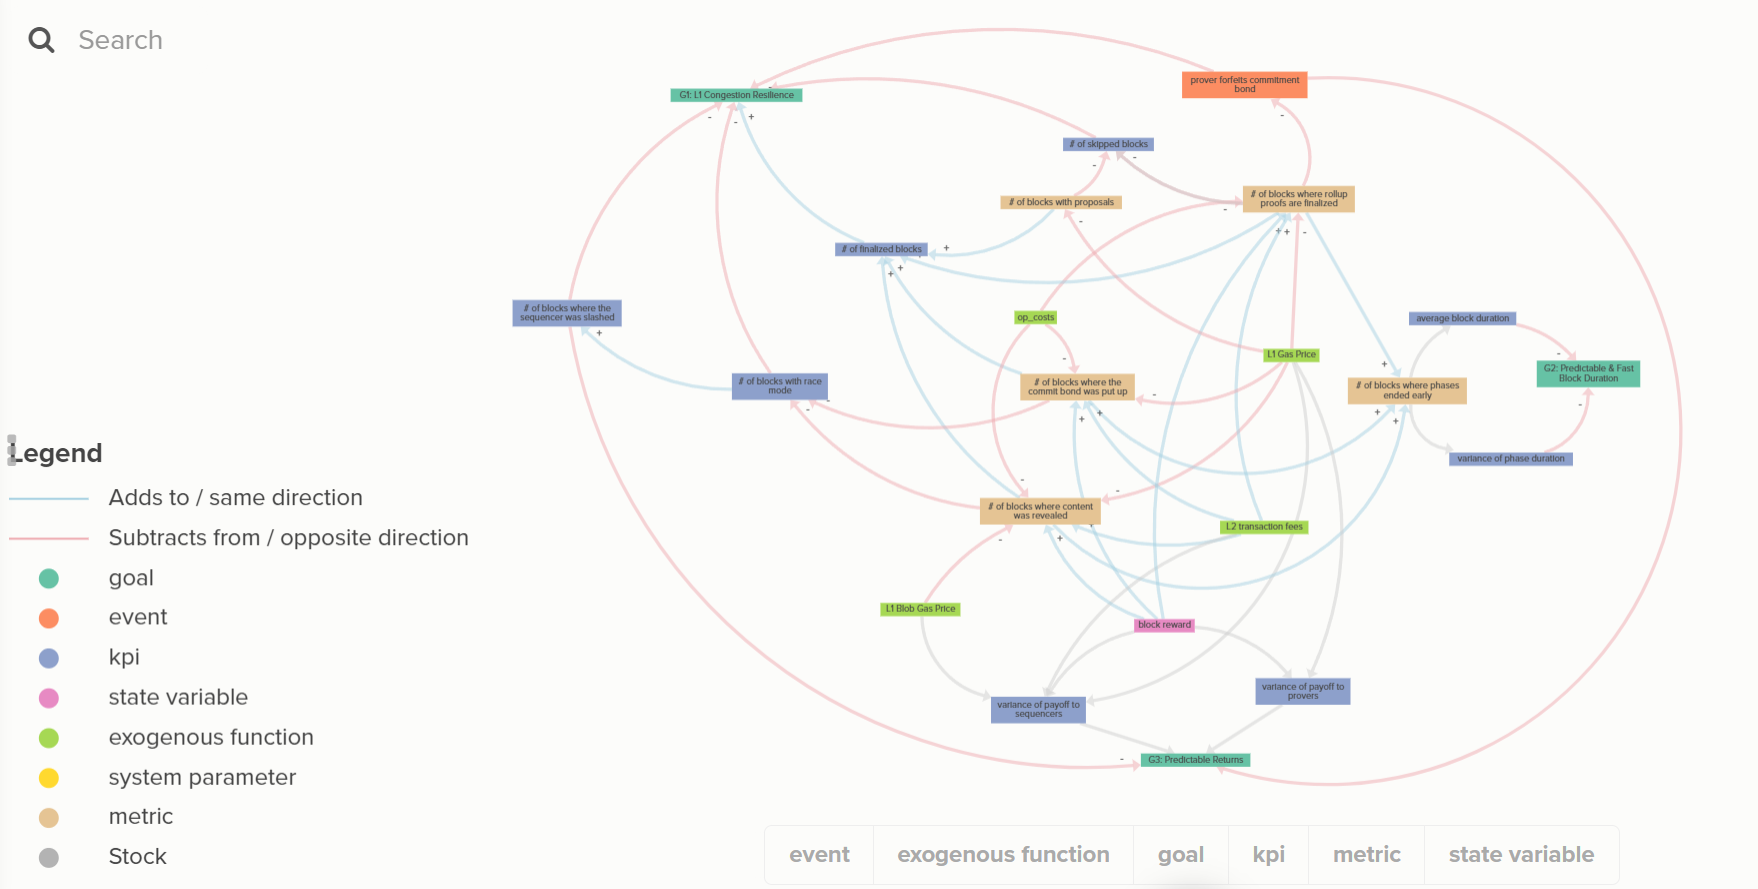

## Experimental Challenge

* It is unclear whether certain phase durations are more susceptible to L1 congestion or censorship
    * Dynamic Phase durations might provide faster block times (less "idle") and might circumvent L1 congestion
    * Fixed Phase durations show UX and reward consistency
* The duration of these phases needs to be tuned for several constraints:
    * Technical Constraint: Is the phase long enough to actually do all the steps? (Assumption for simulation: Technical Feasiblity is given by provided "safe" phase durations)
    * Economic Constraint: Is the phase long enough to actually do all the steps and bring them on L1, while being profitable?
        * This is what we're testing: If L1 gas prices go up ("shock"), will block production be severely impacted?
        * This depends on economic assumptions: When will Sequencers / Provers find it infeasible to pay more for each L1 action?
            * This depends on cost and reward assumptions: If costs are low, and rewards are high, the L1 gas price (and similarly blob gas) increase can more easily be shouldered 
            * Absent knowing more about cost and reward structures, as well as behavioral components (which "type" of agent is more likely to use a 3rd party marketplace? When would they decide to self-prove?) our best approach is to create slots for these assumptions and iteratively "slot in" better assumptions, while sweeping over potential parameter ranges. 


## Sweeping

Our current Parameter Selection under Uncertainty (PSuU) workflow allows us to sweep over cartesian products of parameter combinations. 
By running several (currently 5) Monte-Carlo runs on each combination, we are able to create a large number of trajectories. By computing metrics per trajectory, and then comparing them across trajectories as KPIs, the analysis serves to find out which combinations of parameters is beneficial for individual KPIs. Additionally, the KPIs are grouped into utility functions, where each utility function serves one of the three goals.



## KPIs
A KPI serves to make an assessment over trajectory metrics. There are currently two main distuingishing threshold rules:

- BMaT: Below the Median across Trajectories
    - E.g. for T1 - Having a lower fraction of blocks that enter race mode is preferable, so we want to tune this to be better below the median. 
- LMaT: Larger than the Median across Trajectories
    - E.g. for payoffs - Having a higher payoff per agent (all else equal) is preferable, so we want to tune this to be better above the median. 

By assigning a KPI as 0 or 1, according to above threshold rules, we can use them to increase overall utility functions. 

### Utility Functions

The utility functions take as input the KPI values and sum them up (currently on equal weights). This allows to iterate over large sets of data quickly, assessing whether a trajectory performed better on a Goal than another. 

\begin{align}
\pi_1(C) &= \sum T_i,  T_i \in \mathcal{T}_1\\
\pi_2(C) &= \sum T_i,  T_i \in \mathcal{T}_2\\
\pi_3(C) &= \sum T_i,  T_i \in \mathcal{T}_3\\
\end{align}


### Metrics
The calculation for the below metrics can be seen in `metrics.py`:

|Identifier|Metric|Applicable Goals|Threshold|
|-|-|-|-|
|T1|Fraction of Blocks that entered Race Mode|G1|BMaT|
|T2|Fraction of Blocks that were slashed due to Provers|G1|BMaT|
|T3|Fraction of Blocks that were slashed due to Sequencers|G1|BMaT|
|T4|Fraction of Blocks that were skipped|G1|BMaT|
|T5|Average of Finalized Blocks Duration|G2|BMaT|
|T6|Standard Deviation of Finalized Blocks Duration|G2|BMaT|
|T7|Average of Non-Finalized Blocks Duration|G2|BMaT|
|T8|Standard Deviation of Non-Finalized Blocks Duration|G2|BMaT|
|T9|Standard Deviation of Payoffs to Sequencers|G3|BMaT|
|T10|Standard Deviation of Payoffs to Provers|G3|BMaT|


## The Model



### cadCAD Model
A cadCAD model consists of policies, state update functions and (partial) state_update_blocks (PSuBs).
The model tracks a system state (starting from "Initial State") and updates this state based on PSuBs. 
Each PSuB can include several state update function. 
Each state update function can call logic from several policies.
On each simulation timestep, the model assesses (in order) the PSuBs, and when it hits a condition to trigger, it performs the state update functions, by calling each policy function.
The PSuBs can be seen in `structure.py`
The state update functions are denoted `s_xxx`, while policy functions are denoted `p_xxx`, and both can be seen in `logic.py` 

As an example, following is the state update block for evolving from one block to the next - to do so, the update block first assesses which phase it is currently in, and uses the respective policy functions to decide on any actions. It then updates the state variables according to this logic. 
Note that an L2 block is denoted as `process`. While build-ahead is currently not in spec anymore, it was previously included leading us to plan for several `processes` at the same time. Additionally, having L1 *blocks*, L2 *blocks*, and state update *blocks* gets confusing. 
```
'label': 'Evolve Block Process',
'ignore': False,
'policies': {
    'init_process': p_init_process,
    'select_sequencer': p_select_proposal,
    'submit_commit_bond': p_commit_bond,
    'reveal_block_content': p_reveal_content,
    'submit_block_proof': p_submit_proof,
    'submit_block_proof_content_race': p_race_mode},
'variables': {
    'current_process': s_process,
    'transactions': s_transactions,
    'advance_l1_blocks': s_advance_blocks,
    'slashes_to_sequencers': s_slashes_to_sequencer,
    'slashes_to_provers': s_slashes_to_prover,
    'agents': s_agent_transfer}}
```

## Aztec GdDT Model




#### Time
The model is running on a granular timescale. 

Specifically, timesteps are measured in L1 blocks (aka 12 seconds).

However, if nothing were to happen on a simulation timestep, the simulation skips (and forwards) L1 blocks to increase the time simulated for the same computational complexity. 

This is particularly present with fixed phases: If a phase is successful before the maximum duration (as the relevant event has happened), instead of going through each timestep, we fast-forward to the end of the phase. This increases L1 blocks simulated, but only increases simulation timesteps by one. This can result in more L1 blocks simulated than simulation timesteps performed. 



### Agents and Actions
We instantiate several different agents according to classes.

**Sequencers and Provers** inherit from the same class. They have an ID, a balance, some stake (or none) and are either a Sequencer, a Prover, or both.

**Relays** are used as a separate agent, without balance or stake, to make sure that rewards are tracked correctly.

**L1 builder** is a single hard-coded agent, which serves to track race mode rewards. 

**Burn** is a burn sink, where any tokens that are burnt are sent to for tracking purposes. 

As Sequencers are the main agent type, they show different behavior throughout the model.
Specifically, they decide to make (or not make) certain actions based assessments:


#### Test 1: Willingness to do an action

Several factors play into this:
* Does an agent want to make an action?
* Can an agent make an action? 

When agents have to make a transaction, such as revealing their block content, they test whether to make it based on a probability. This can be seen in the policy function for phases, such as in `p_commit_bond` in `logic.py`
```
agent_decides_to_reveal_commit_bond = bernoulli_trial(
                        probability=params["commit_bond_reveal_probability"])
```
For the purpose of this scenario, where we are not testing malicious or accidental actors, the cumulative probability of an agent performing the action during the duration of the phase is currently set to `0.99` and distributed over each timestep. This emulates the fact that it is more likely that an agent performs their action towards the end of a phase.

*Limitation:*
* Agents do not show different willingness based on type of agent, or other endogenous / exogenous factors. 

*Slot:* 

* This slot could be adapted with insights from Market Design, such as behavioral models, costs that affect willingness, etc.
* Similarly, anybody can propose their own assumptions on agent behavior, for us to slot them in and see what happens. 

#### Test 2: Profitability of completing an action

When agents have to make a transaction, such as revealing their block content, they test whether it is profitable for them to continue the action.

```
# NOTE: Costs now include gas fees and safety buffer.
gas: Gas = params["gas_estimators"].commitment_bond(state)
fee = gas * state["gas_fee_l1"]
# Assumption: Agents have extra costs / profit considerations and need a safety buffer
SAFETY_BUFFER = params['safety_factor_commit_bond'] * fee

expected_l2_blocks_per_day = params['l1_blocks_per_day'] / \
    max_phase_duration(params)

expected_rewards = params['daily_block_reward']
expected_rewards *= rewards_to_sequencer(params)
expected_rewards /= expected_l2_blocks_per_day

expected_costs: float = params["op_cost_sequencer"]
expected_costs += fee
expected_costs += SAFETY_BUFFER
expected_costs *= params['gwei_to_tokens']

payoff_reveal = expected_rewards - expected_costs
```

*Limitation:*
* This simplification currently computes the share of the block rewards for the block, as well as the total costs consisting of the gas of the current transaction to be evaluated, with current gas price, taking a Safety Buffer as a multiplier of expected gas fees for profit margin, and a constant parameter `op_cost_sequencer` to indicate that agents have their own operational costs to cover as well.

*Slot:* 
* This slot could be adapted with insights from Market Design, such as cost models, reward assumptions, fee structures, etc.
* Similarly, anybody can propose their own assumptions on costs and rewards, for us to slot them in and see what happens. 

#### Censorship preventing an action

While willingness and profitability assumptions cover most decisions, the model also includes a gas threshold and blobgas threshold that agents test again when making decisions. This threshold can be set quite high, to mark gas prices where agents are prohibited from interacting with L1, through censorship or otherwise.
This might be in the future reduced to a more accurate profitability functional form, but currently serves to mark absolute censorship thresholds. This can be changed through `params.py`:

```
gas_threshold_for_tx=70, 
blob_gas_threshold_for_tx=50,  
```

*Limitation:* 
* This trigger serves to induce a total shutout from L1. When gas or blob gas prices rise above the current treshold, agents cannot make L1 transactions anymore. When set too low (or sweep values include values that are too low), this can result in no sequencer making proposals, resulting in mass skipped blocks. 

*Slot:* 
* This slot could be adapted by creating a stochastic time series of L1 blocks that are censored, such as the distribution of Lido validator slots, or specific builder distributions. 
* Similarly, anybody can propose their own assumptions on agent behavior, for us to slot them in and see what happens.

### Agent actions happening:

When agents have to make a transaction, such as revealing their block content, they test `Willingness`, `Profitability`, and `Censorship`. 
If all those tests are `True`, they make the transaction, marking the end of the phase. Depending on fixed or dynamical phase durations, we then either fast-forward the simulation or move to the next phase directly.

As an example, take this block of code from the policy logic for the commitment bond phase:
* First, profitability is tested through a reward and cost slot. 
* Then, willingness is tested. As the current simulation is not geared towards malicious agents or hardware failures, the cumulative probability over all timesteps of the phase is set to 0.99. 
* Finally, censorship is tested. The gas (and blob gas) thresholds define a complete shutout, so they should be set in accordance with the profitability values and gas price time series. 
* If all tests are successful, the agent makes a decision whether to self-prove or use a third party proving marketplace.
* Then, the agent makes the commitment_bond transaction and we can transition to the next phase. 

```
if payoff_reveal >= 0:

    # If duration is not expired, do  a trial to see if bond is commited
    agent_decides_to_reveal_commit_bond = bernoulli_trial(
        probability=trial_probability(params['phase_duration_commit_bond_max_blocks'],
                                        params['final_probability'])
    )
    gas_fee_l1_acceptable = (
        state["gas_fee_l1"] <= params["gas_threshold_for_tx"]
    )
    if agent_decides_to_reveal_commit_bond and gas_fee_l1_acceptable:
        updated_process = copy(process)
        lead_seq: Agent = state['agents'][process.leading_sequencer]
        proposal_uuid = process.tx_winning_proposal
        proving_market_is_used = bernoulli_trial(
            params["proving_marketplace_usage_probability"]
        )
        if proving_market_is_used:
            provers: list[AgentUUID] = [
                a_id
                for (a_id, a) in state["agents"].items()
                if a.is_prover and a.balance >= bond_amount
            ]
```

### 3rd party proving marketplace usage: 

As agents might either be self-proving or using a 3rd party prover marketplace through Sidecar, we currently set a global constant probability that agents use to decide for either possibility when confronted with the choice. 


*Limitation:*
* All sequencers currently decide through the same global probability, at the time of decision, whether to self prove or use 3rd party marketplaces.
* This could be adapted to be specific to agents, instantiated through their class, with probabilities [0, 1] to denote agent types. 

*Slot:*
* This slot could be adapted in various ways, from specific cost assumptions resulting from 3rd party proving, to different behavior by agents, or simply just sweeping over different distributions of 3rd party proving usage prevalence. 

### Rewards and Slashings: 

There are currently three possible slashings in the model. Each of these has a respective paramater, which is currently a global constant. The Sequencer Slashings can be adapted in `params.py`, while the Prover Slashing can be adapted directly in `logic.py`: 

* No Commitment Bond is put up: Lead Sequencer gets slashed.
* Block Content is not revealed: Lead Sequencer gets slashed.

```
SLASH_PARAMS = SlashParameters(
    failure_to_commit_bond=2,
    failure_to_reveal_block=1) #Both in ETH
```  


* No Rollup Proof is submitted: Prover ID gets slashed (which might be the same as Lead Sequencer, in case of self-proving)
```
who_to_slash = commit_bond.prover_uuid
how_much_to_slash = commit_bond.bond_amount  #full commitment bond is slashed
```

In all cases, the slashed amount goes to the burn sink. 

*Note:*
* When simulating small numbers of agents, without sufficient starting balance, they don't necessarily earn enough to top back up. If enough sequencers drop, no more proposals are put forward and blocks are mass-skipped. If too many 3rd party provers drop out, sequencers try to self-prove, but can get their balance slashed for the commitment bond amount and drop out too. 

### L2 Transactions 

As rewards and costs are assumed to not be constants, but instead depend on the transactions made, the model needs some way to take these into account. Since we are not necessarily interested in the granular dynamics of individual L2 transactions, but instead on their effect on rewards and costs, the model emulates a simplified version.
In the state update function `s_transactions_new_proposals`, the following logic can be found:
```
size = params["tx_estimators"].proposal_average_size(state)
public_share = 0.5  # the share of the block as public function calls, which could be used for MEV
```
Which consumes from `params.py`:
```
DEFAULT_DETERMINISTIC_TX_ESTIMATOR = UserTransactionEstimators(
    transaction_count=lambda _: 1,  # number of transactions
    proposal_average_size=lambda _: 100,  # average size in MB 
    transaction_average_fee_per_size=lambda _: 50.5,  # fee per MB)
```

This lets the model get more granular blob costs and transaction rewards to agents. 

*Limitation:*
* Larger transactions (in MB) only limitedly proxy a higher fee, while similarly setting averages per proposal is a limited way to set transaction fee rewards. 

*Slot:*
* Knowing more about the cost and fee assumptions surrounding transactions would let us slot in more precise transaction fee assumptions, as well as DA and compute costs. 

### Economic Assets

#### Tokens 

As currently no empirical data or clear estimate exists on AZT tokens, the model tracks all assets denominated in ETH (denoted "token"). While Gas Prices use Gwei, a conversion (1e^9) is used to exchange between them. 
Currently, there exist rewards, cashbacks and burns. 
* **Rewards:**
    * Block Rewards: We use a daily block reward, which is distributed over the max amount of blocks each day to stay consistent for phase durations
    * Transaction Fees: While empirical amounts are unclear, we use a bucket of transactions and fees per transaction to include. 
* **Cashback:**
    * Originally used for fee cashbacks when certain actors make L1 transactions, this is currently disabled. 
* **Burn:**
    * When users are slashed, we send their funds to the burn sink. This could at any point be changed to go to a community treasury or similar.

Unless we are testing initial launch conditions, the system starts with some prior ('Initial') state of those, denoted as initial cumulative rewards. These can be set in `params.py`:
```
INITIAL_CUMM_REWARDS = 200.0 
INITIAL_CUMM_CASHBACK = 50.0
INITIAL_CUMM_BURN = 50.0
```

By summing the balance and stake of all actors we can retrieve the current circulating supply. 

#### Gas:
Each L1 transaction agents need to complete costs them L1 fees.
The assumptions for needed gas can be adapted in `params.py`:

```
DEFAULT_DETERMINISTIC_GAS_ESTIMATOR = L1GasEstimators(
    proposal=lambda _: 100_000,  # type: ignore
    commitment_bond=lambda _: 100_000,  # type: ignore
    content_reveal=lambda _: 81_000,  # type: ignore
    content_reveal_blob=lambda _: 500_000,  # type: ignore
    rollup_proof=lambda _: 700_000,  # type: ignore)
```

The gas price is initialized with a mean value and standard deviation, as well as a timeseries. 
In the current congestion simulation, we initialize a "steady state", which emulates regular L1 behavior. These values can be adapted in `params.py`:
```
MEAN_STEADY_STATE_L1 = 30
DEVIATION_STEADY_STATE_L1 = 2
MEAN_STEADY_STATE_BLOB = 15
DEVIATION_STEADY_STATE_BLOB = 2
```

Similarly, two shock scenarios are imposed over the steady state gas price time series:
1. **Continuous Shocks:**
Emulate a big singular shock, where gas prices are at steady state for the first 25% of the simulation timesteps, then rise sharply, then drop again for the final 25%.
Can be seen and adapted in `params.py`:
```
## Begin: single shock gas estimators defined 
L1_SHOCK_AMOUNT = 100
BLOB_SHOCK_AMOUNT = 100
initial_time = floor(0.25 * TIMESTEPS)  # XXX: 25% of timesteps
final_time = floor(0.25 * TIMESTEPS)  # XXX: 25% of timesteps
```
2. **Intermittent Shocks:**
Intermittent Shocks emulate reoccuring shocks, modeled through waves. They can be tweaked both on amplitude as well as period of the wave. Can be seen and adapted in `params.py`:


```
## Begin: intermittent shock gas estimators defined 
L1_INTER_SHOCK_AMPLITUDE = 100  # Amplitude of wave
L1_INTER_SHOCK_PERIOD = 10  # Period of wave
num_points = (TIMESTEPS - final_time) - initial_time
t = np.arange(initial_time, initial_time + num_points)
```

### Protocol Parameters

The following are protocol parameters that Aztec Labs or later governance participants can decide to adapt.

When values are given as a list, this means that the simulation is set-up to sweep over them by creating parameter combinations. 

Sweeping over these lets us test a wide variety of combinations for their effect on KPIs. 

*Note:* The lower bound per upper bound parameter decides whether the lower bound of a phase duration is set to 0 (phase can end early), or to the upper bound (phase always goes through entire duration). Sweeping over these two values always creates either fixed phase durations, or dynamic phase durations. 

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| `ProposalPhaseUpperBound`  | `phase_duration_proposal_max_blocks` | (3, 6, 12) | L1 blocks |
| `CommitPhaseUpperBound`       | `phase_duration_commit_bond_max_blocks` | (3, 6, 12) | L1 blocks |
| `RevealPhaseUpperBound`   | `phase_duration_reveal_max_blocks` | (3, 12, 24) | L1 blocks |
| `ProvingPhaseUpperBound`      | `phase_duration_rollup_max_blocks`  | (15, 40, 80) | L1 blocks |
| `RaceModePhaseUpperBound`  | `phase_duration_race_max_blocks`  | (3, 6)  | L1 blocks |
| `CommitPhaseLowerBoundPerUpperBound`  | `phase_duration_commit_bond_min_blocks`  | (0, 1)  | LBpUB |
| `RevealPhaseLowerBoundPerUpperBound`  | `phase_duration_reveal_min_blocks`  | (0, 1)  | LBpUB |
| `ProvingPhaseLowerBoundPerUpperBound`  | `phase_duration_rollup_min_blocks`  | (0, 1)  | LBpUB |
| `RaceModePhaseLowerBoundPerUpperBound`  | `phase_duration_race_min_blocks`  | (0, 1)  | LBpUB |
| `BlockRewardConstant`  | `reward_per_block`  | ($\{\pi_-, \pi+\}$)  | GWei |
| `CommitBondSize`  | `commit_bond_amount`  | $\{B_{s,-}, B_{s,+}\}$  | GWei |
| `Reward Share of Provers`  | `rewards_to_provers` | (0.0, 0.1, 0.5) | percentage of rewards |
| `Reward Share of Relays`  | `rewards_to_relay` | (0.0, 0.03, 0.1) | percentage of rewards |

## Computational Complexity

A single run (or even a limited amount of trajectories) can easily be done locally. 

A single trajectory, custom run (setting individual parameters) is useful for testing and sanity checking. A custom_run.nb is available to test different param values, and read statistics from the resulting dataframe.

For parameter sweeps, the psuu_run is used. A test_psuu_run.ipynb is available to test the psuu workflow. 

For large parameter sweeps, with high amounts of trajectories, we use cloud compute to handle both the large datasets for analysis, but also the simulation runs themselves. 